# Final Project

### Background

A hummingbird is one of the smallest birds in the world but has a significant impact as a pollinator and indicator of a changing climate. There are 366 species of hummingbirds that span the Americas, from South America all the way to Alaska (US Fish & Wildlife Service, 2025). While all species follow a migratory pattern, these patterns vary based on the species of hummingbird, climate, and available natural resources. 

There are five hummingbird species common to Colorado, some even arriving in the same region at the same time. Guevara notes that “species with similar morphological traits are more likely to compete for the same resources and are less likely to coexist.” (Guevara et al., 2023) Notably, this is a concern because land-use changes can impact where and how these species access resources, especially species such as hummingbirds with unique migratory patterns.

In this study I would like to understand the migratory patterns of two hummingbirds common to the Boulder area. If two species of hummingbird arrive in the same area at the same time, the climatological and land-use changes in the area will heavily impact the competition between hummingbird species. Future research could look at how hummingbird species migratory patterns align with annual vegetative growth and health. 

### Methods
	
The area of focus for this project is Colorado. Therefore, rather than the entire North American ecoregion, this project will focus on Region 8, which includes the Rocky Mountain region of Utah, Colorado, Wyoming, Montana, North Dakota, and South Dakota. This will require downloading a different shape file from the ecoregion API. [More information on Ecoregions of EPA Region 8 are found here.](https://dmap-prod-oms-edc.s3.us-east-1.amazonaws.com/ORD/Ecoregions/reg8/epa_reg8_f.pdf)

The study will look at two of the more prominent hummingbird species in Colorado, the Ruby-Throated Hummingbird (Archilochus colubris) and the Broad-Tailed Hummingbird (Selasphorus platycercus). This will require downloading two different species from the GBIF API. Future research could review all hummingbird species common in Colorado.


## Step 1: Migration Data Download

In this section, I import all the necessary python packages. I also ensure directories are created to keep all the data and resources for the project organized. In this case, that requires a folder for downloading GBIF data for the Ruby-Throated hummingbird, the Broad-Tailed hummingbird, the North America Ecoregion, and Ecoregion 8 (High Plains and Mountains that include Colorado).

In [2]:
# Import needed Python libraries
import time
import zipfile
from getpass import getpass
from glob import glob

import pygbif.occurrences as occ
import pygbif.species as species
import requests

# Python Standard Library Packages
import os
import pathlib

# Other Packages
import earthpy # Manage local data
import pandas as pd # Work with tabular data
import geopandas as gpd # Work with geospatial vector data
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Get month names
import calendar

# Libraries for Dynamic mapping
import cartopy.crs as ccrs
import hvplot.pandas
import panel as pn

In [3]:
# Create data directory
data_dir = os.path.join(

    ### Home directory
    pathlib.Path.home(),

    ### Make folders
    'earth-analytics',
    'data',

    ### Project directory for this assignment
    'final-hummbird', 
)

## Make the path
os.makedirs(data_dir, exist_ok=True)


## STEP 2: Register and log in to GBIF

To download data from GBIF, we must login.

In [4]:
####--------------------------####
#### DO NOT MODIFY THIS CODE! ####
####--------------------------####
# This code ASKS for your credentials 
# and saves it for the rest of the session.
# NEVER put your credentials into your code!!!!

# GBIF needs a username, password, and email 
# All 3 need to match the account
reset = True

# Request and store username
if (not ('GBIF_USER'  in os.environ)) or reset:
    os.environ['GBIF_USER'] = input('GBIF username:')

# Securely request and store password
if (not ('GBIF_PWD'  in os.environ)) or reset:
    os.environ['GBIF_PWD'] = getpass('GBIF password:')
    
# Request and store account email address
if (not ('GBIF_EMAIL'  in os.environ)) or reset:
    os.environ['GBIF_EMAIL'] = input('GBIF email:')

## STEP 3: Get the taxon key from GBIF

One of the tricky parts about getting occurrence data from GBIF is that
species often have multiple names in different contexts. Luckily, GBIF
also provides a Name Backbone service that will translate scientific and
colloquial names into unique identifiers. GBIF calls these identifiers
**taxon keys**. 



In [5]:
## Get the 2 distinct species key from GBIF 
backbone_ruby = species.name_backbone(name='Archilochus colubris')
backbone_broad = species.name_backbone(name='Selasphorus platycercus')

## Additonal species for future projects
backbone_chin = species.name_backbone(name='Archilochus alexandris')

species_key_ruby = backbone_ruby['usageKey']
species_key_broad = backbone_broad['usageKey']

## Additional species for future projects
species_key_chin = backbone_chin['usageKey']

## Retrieve usage key and confirm existence
print("The usage key for Ruby is: " , species_key_ruby)
print("The usage key for Broad-Tail is: ", species_key_broad)

## Additional species for future projects
print("The usage key for Black-Chin is: ", species_key_chin)

The usage key for Ruby is:  5228514
The usage key for Broad-Tail is:  2476844
The usage key for Black-Chin is:  5228513


## STEP 4: Download data from GBIF

Downloading GBIF data is a multi-step process. 

For this final project, we will be using two different species of hummingbird, so will need to run this information twice.

In [6]:
# Create data directory for the Ruby-throated hummingbird
ruby_dir = os.path.join(

    ### Home directory
    pathlib.Path.home(),

    ### Make folders
    'earth-analytics',
    'data',

    ### Project directory for this assignment
    'final-hummbird', 
    'ruby'
)

## Make the path
os.makedirs(ruby_dir, exist_ok=True)

In [7]:
# Only download once
gbif_pattern_ruby = os.path.join(ruby_dir, '*.csv')

if not glob(gbif_pattern_ruby):
    
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
            f"taxonKey = {species_key_ruby}",
            "hasCoordinate = True",
            f"year = 2024",
        ])
        # Take first result
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

    # Wait for the download to build
    dld_key = os.environ['GBIF_DOWNLOAD_KEY']

    # use the occurrence command module in pygbif to get the metadata
    wait = occ.download_meta(dld_key)['status']

    # check if the status of the download = "SUCCEEDED"
    # wait and loop through until it finishes
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(dld_key)['status']
        time.sleep(5)

    # Download GBIF data
    dld_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path=ruby_dir)
    dld_path = dld_info['path']

    # Unzip GBIF data
    with zipfile.ZipFile(dld_path) as dld_zip:
        dld_zip.extractall(path=ruby_dir)
        
    # Clean up the .zip file
    os.remove(dld_path)

    

else: print("Done!") # If file already exists in folder    

# Find the extracted .csv file path (first result)
gbif_path_ruby = glob(gbif_pattern_ruby)[0]

#Rename the file to a descriptive name
csv_filename = os.path.basename(gbif_path_ruby)

ruby_gbif = "ruby-gbif.csv"
new_path1 = os.path.join(ruby_dir, ruby_gbif)

os.rename(gbif_path_ruby, new_path1)

print(f"Renamed {csv_filename} → {ruby_gbif}")

Done!
Renamed ruby-gbif.csv → ruby-gbif.csv


In [8]:
# Create data directory
broad_dir = os.path.join(

    ### Home directory
    pathlib.Path.home(),

    ### Make folders
    'earth-analytics',
    'data',

    ### Project directory for this assignment
    'final-hummbird', 
    'broad'
)

## Make the path
os.makedirs(broad_dir, exist_ok=True)

In [9]:
# Only download once
gbif_pattern_broad = os.path.join(broad_dir, '*.csv')

if not glob(gbif_pattern_broad):
    
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY_1' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
            f"taxonKey = {species_key_broad}",
            "hasCoordinate = True",
            f"year = 2024",
        ])
        # Take first result
        os.environ['GBIF_DOWNLOAD_KEY_1'] = gbif_query[0]

    # Wait for the download to build
    dld_key = os.environ['GBIF_DOWNLOAD_KEY_1']

    # use the occurrence command module in pygbif to get the metadata
    wait = occ.download_meta(dld_key)['status']

    # check if the status of the download = "SUCCEEDED"
    # wait and loop through until it finishes
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(dld_key)['status']
        time.sleep(5)

    # Download GBIF data
    dld_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY_1'], 
        path=data_dir)
    dld_path = dld_info['path']

    # Unzip GBIF data
    with zipfile.ZipFile(dld_path) as dld_zip:
        dld_zip.extractall(path=broad_dir)
        
    # Clean up the .zip file
    os.remove(dld_path)

    

else: print("Done!") # If file already exists in folder    

# Find the extracted .csv file path (first result)
gbif_path_broad = glob(gbif_pattern_broad)[0]

#Rename the file to a descriptive name
csv_filename = os.path.basename(gbif_path_broad)

broad_gbif = "broad-gbif.csv"
new_path2 = os.path.join(broad_dir, broad_gbif)

os.rename(gbif_path_broad, new_path2)

print(f"Renamed {csv_filename} → {broad_gbif}")

Done!
Renamed broad-gbif.csv → broad-gbif.csv


## Step 5: Define Study Area: Ecoregions of North America and import GBIF data

In this section:
- Collect the data directy for the ecoregion of North America and ensure it is plotting correctly
- Load the collected GBIF data into the notebook as a dataframe
- Change the data from a data frame (DF) to a geodatafram (GDF)

In [10]:
### Get url for ecoregions
ecoregion_url = ("https://storage.googleapis.com/"
       "teow2016/Ecoregions2017.zip")

### Make them machine readable
eco_dir = os.path.join(data_dir, "ecoregions")

### Make the ecoregions directory
os.makedirs(eco_dir, exist_ok = True)

### Join ecoregions shapefile path
eco_path = os.path.join(eco_dir, "ecoregions.shp")

### Download the data (once)
if not os.path.exists(eco_path):
    eco_gdf = gpd.read_file(ecoregion_url)
    eco_gdf.to_file(eco_path)

<Axes: >

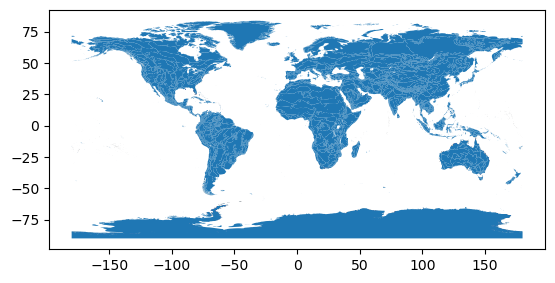

In [11]:
# Open up the ecoregions boundaries
ecoregion_gdf = (
    gpd.read_file(eco_path)
    [['OBJECTID', 'ECO_NAME', 'SHAPE_AREA', 'geometry' ]]
   
)
    
# Plot the ecoregions quickly to check download
ecoregion_gdf.plot()

In [12]:
#View the data
ecoregion_gdf.head()

,OBJECTID,ECO_NAME,SHAPE_AREA,geometry
0,1.0,Adelie Land tundra,0.038948,"MULTIPOLYGON (((158.7141 -69.60657, 158.71264 ..."
1,2.0,Admiralty Islands lowland rain forests,0.170599,"MULTIPOLYGON (((147.28819 -2.57589, 147.2715 -..."
2,3.0,Aegean and Western Turkey sclerophyllous and m...,13.844952,"MULTIPOLYGON (((26.88659 35.32161, 26.88297 35..."
3,4.0,Afghan Mountains semi-desert,1.355536,"MULTIPOLYGON (((65.48655 34.71401, 65.52872 34..."
4,5.0,Ahklun and Kilbuck Upland Tundra,8.196573,"MULTIPOLYGON (((-160.26404 58.64097, -160.2673..."


In [13]:
# Check that files were extracted into the correct directory
print("Files in directory after extraction:", os.listdir(data_dir))
print("Ruby folder:", os.listdir(ruby_dir))
print("Broad folder:", os.listdir(broad_dir))

Files in directory after extraction: ['ruby', 'ecoregions8', 'ecoregions', 'ecoregions6', 'ecoregion6', 'broad']
Ruby folder: ['ruby-gbif.csv']
Broad folder: ['broad-gbif.csv']


In [14]:
## Download a different zoomed in ecoregion
eco_8_url = "https://dmap-prod-oms-edc.s3.us-east-1.amazonaws.com/ORD/Ecoregions/reg8/reg8_eco_l3.zip"

# Local directory to store ecoregions
eco_8_dir = os.path.join(data_dir, "ecoregions8")
os.makedirs(eco_8_dir, exist_ok=True)

# Zip path
eco_8_zip = os.path.join(eco_8_dir, "reg8_eco_l3.zip")

# Path to the shapefile (inside extracted folder)
eco_8_path = os.path.join(eco_8_dir, "reg8_eco_l3.shp")


# 1. Download the ZIP if not already present
if not os.path.exists(eco_8_zip):
    print("Downloading ecoregions Level III ZIP...")
    r = requests.get(eco_8_url)
    with open(eco_8_zip, "wb") as f:
        f.write(r.content)
    print("Download complete.")


# 2. Extract the shapefile if not already extracted
if not os.path.exists(eco_8_path):
    print("Extracting ZIP...")
    with zipfile.ZipFile(eco_8_zip, 'r') as z:
        z.extractall(eco_8_dir)
    print("Extraction complete.")


# 3. Read the shapefile
eco_8_gdf = gpd.read_file(eco_8_path)
eco_8_gdf


,US_L3CODE,US_L3NAME,NA_L3CODE,NA_L3NAME,NA_L2CODE,NA_L2NAME,NA_L1CODE,NA_L1NAME,STATE_NAME,EPA_REGION,L3_KEY,L2_KEY,L1_KEY,Shape_Leng,Shape_Area,geometry
0,12,Snake River Plain,10.1.8,Snake River Plain,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,Wyoming,8,12 Snake River Plain,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,3.048079e+04,2.998087e+07,"POLYGON ((-1202710.657 2395947.963, -1202705.1..."
1,13,Central Basin and Range,10.1.5,Central Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,Utah,8,13 Central Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,1.884163e+06,8.226907e+10,"POLYGON ((-1373196.619 2231035.62, -1373090.99..."
2,14,Mojave Basin and Range,10.2.1,Mojave Basin and Range,10.2,WARM DESERTS,10,NORTH AMERICAN DESERTS,Utah,8,14 Mojave Basin and Range,10.2 WARM DESERTS,10 NORTH AMERICAN DESERTS,2.392012e+05,1.950185e+09,"POLYGON ((-1564408.121 1735198.574, -1564336.8..."
3,15,Northern Rockies,6.2.3,Columbia Mountains/Northern Rockies,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,Montana,8,15 Northern Rockies,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,1.147075e+06,2.912228e+10,"POLYGON ((-1394930.775 3014349.817, -1394410.4..."
4,16,Idaho Batholith,6.2.15,Idaho Batholith,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,Montana,8,16 Idaho Batholith,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,1.959632e+03,2.373682e+05,"POLYGON ((-1424255.375 2779017.836, -1424349.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,80,Northern Basin and Range,10.1.3,Northern Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,Utah,8,80 Northern Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,1.720131e+04,1.410431e+07,"POLYGON ((-1347355.687 2227996.287, -1346579.7..."
70,80,Northern Basin and Range,10.1.3,Northern Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,Utah,8,80 Northern Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,4.742449e+03,1.276694e+06,"POLYGON ((-1351241.975 2227904.242, -1351548.0..."
71,80,Northern Basin and Range,10.1.3,Northern Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,Utah,8,80 Northern Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,1.141397e+04,6.992450e+06,"POLYGON ((-1358983.645 2227135.928, -1359087.3..."
72,80,Northern Basin and Range,10.1.3,Northern Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,Utah,8,80 Northern Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,9.097700e+03,3.555776e+06,"POLYGON ((-1372633.884 2231096.375, -1372826.1..."


In [15]:
eco_8_gdf.head()

,US_L3CODE,US_L3NAME,NA_L3CODE,NA_L3NAME,NA_L2CODE,NA_L2NAME,NA_L1CODE,NA_L1NAME,STATE_NAME,EPA_REGION,L3_KEY,L2_KEY,L1_KEY,Shape_Leng,Shape_Area,geometry
0,12,Snake River Plain,10.1.8,Snake River Plain,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,Wyoming,8,12 Snake River Plain,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,3.048079e+04,2.998087e+07,"POLYGON ((-1202710.657 2395947.963, -1202705.1..."
1,13,Central Basin and Range,10.1.5,Central Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,Utah,8,13 Central Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,1.884163e+06,8.226907e+10,"POLYGON ((-1373196.619 2231035.62, -1373090.99..."
2,14,Mojave Basin and Range,10.2.1,Mojave Basin and Range,10.2,WARM DESERTS,10,NORTH AMERICAN DESERTS,Utah,8,14 Mojave Basin and Range,10.2 WARM DESERTS,10 NORTH AMERICAN DESERTS,2.392012e+05,1.950185e+09,"POLYGON ((-1564408.121 1735198.574, -1564336.8..."
3,15,Northern Rockies,6.2.3,Columbia Mountains/Northern Rockies,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,Montana,8,15 Northern Rockies,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,1.147075e+06,2.912228e+10,"POLYGON ((-1394930.775 3014349.817, -1394410.4..."
4,16,Idaho Batholith,6.2.15,Idaho Batholith,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,Montana,8,16 Idaho Batholith,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,1.959632e+03,2.373682e+05,"POLYGON ((-1424255.375 2779017.836, -1424349.2..."


<Axes: >

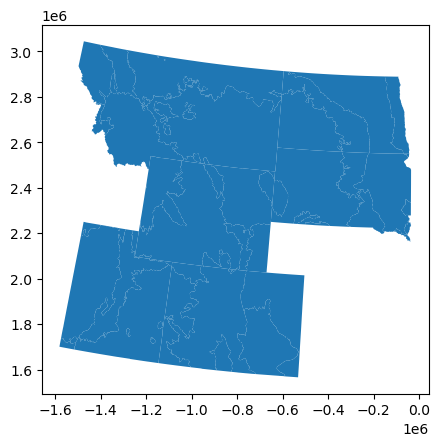

In [16]:
# Open up the ecoregions boundaries
eco_8_gdf = (
    gpd.read_file(eco_8_path)
    [['US_L3CODE', 'US_L3NAME', 'Shape_Area', 'geometry' ]]
   
)
    
# Plot the ecoregions quickly to check download
eco_8_gdf.plot()

## Step 6: Load GBIF dataframe and turn into geodataframes

In [17]:
# Load the GBIF dataframe for the ruby-throated hummingbird
gbif_ruby_df = pd.read_csv(
    new_path1,
    delimiter = '\t',
    index_col='gbifID',
    usecols = ['gbifID', 'decimalLatitude', 'decimalLongitude', 'month'])

### Check out data
gbif_ruby_df.head()

,decimalLatitude,decimalLongitude,month
gbifID,,,
4948005334,41.315200,-72.920300,9.0
5159684301,41.303649,-72.927627,9.0
4950101970,39.365147,-86.508346,9.0
4910889783,41.400784,-81.887628,5.0
4867924503,20.501114,-86.944814,4.0


In [18]:
# Load the GBIF dataframe for the broad-tailed hummingbird

gbif_broad_df = pd.read_csv(
    new_path2,
    delimiter = '\t',
    index_col='gbifID',
    usecols = ['gbifID', 'decimalLatitude', 'decimalLongitude', 'month'])

### Check out data
gbif_broad_df.head()

,decimalLatitude,decimalLongitude,month
gbifID,,,
5196098037,39.747056,-105.227654,10
5196098277,39.581335,-104.978674,8
5196115619,39.836765,-105.090057,6
5196115622,39.577505,-105.303160,6
5196115680,40.357246,-105.549468,5


In [19]:
## Convert GBIF data to GDF for Ruby-Throated Hummingbird
gbif_ruby_gdf = (
    gpd.GeoDataFrame(
        gbif_ruby_df, 
        geometry=gpd.points_from_xy(
            gbif_ruby_df.decimalLongitude, 
            gbif_ruby_df.decimalLatitude), 
        crs="EPSG:4326") #Using latitude and longitude in degrees
    # Select the desired columns
    [['month', 'geometry']]
)

# View the data
gbif_ruby_gdf

,month,geometry
gbifID,,
4948005334,9.0,POINT (-72.9203 41.3152)
5159684301,9.0,POINT (-72.92763 41.30365)
4950101970,9.0,POINT (-86.50835 39.36515)
4910889783,5.0,POINT (-81.88763 41.40078)
4867924503,4.0,POINT (-86.94481 20.50111)
...,...,...
5288307497,11.0,POINT (-104.81715 19.30815)
4882314484,5.0,POINT (-82.50931 41.91015)
4882844007,5.0,POINT (-82.51074 41.91552)


In [20]:
## Convert GBIF data to GDF for Broad-Tailed Hummingbird
gbif_broad_gdf = (
    gpd.GeoDataFrame(
        gbif_broad_df, 
        geometry=gpd.points_from_xy(
            gbif_broad_df.decimalLongitude, 
            gbif_broad_df.decimalLatitude), 
        crs="EPSG:4326") #Using latitude and longitude in degrees 4326
    # Select the desired columns
    [['month', 'geometry']]
)

# View the data
gbif_broad_gdf

,month,geometry
gbifID,,
5196098037,10,POINT (-105.22765 39.74706)
5196098277,8,POINT (-104.97867 39.58134)
5196115619,6,POINT (-105.09006 39.83676)
5196115622,6,POINT (-105.30316 39.5775)
5196115680,5,POINT (-105.54947 40.35725)
...,...,...
4907350423,7,POINT (-110.7147 32.4104)
4907345064,7,POINT (-110.7147 32.4104)
4605963377,2,POINT (-92.0825 15.156)


In [21]:
# Confirm the data is a Geo Data Frame
print(gbif_ruby_gdf.info())
print(gbif_broad_gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 457548 entries, 4948005334 to 5151716362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   month     457547 non-null  float64 
 1   geometry  457548 non-null  geometry
dtypes: float64(1), geometry(1)
memory usage: 10.5 MB
None
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 82390 entries, 5196098037 to 4940937149
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   month     82390 non-null  int64   
 1   geometry  82390 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 1.9 MB
None


## Step 7: Consolidate dataframe data into ecoregion data

In [22]:
eco8_ruby_gdf = (
    eco_8_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_ruby_gdf.crs)

    # Find ecoregion for each observation
    .sjoin(
        gbif_ruby_gdf,
        how = 'inner',
        predicate = 'contains')

        [['US_L3CODE', 'month']]
        .rename(columns = {'US_L3CODE' : 'ecoregion'})
)
# Check it out
eco8_ruby_gdf

,ecoregion,month
22,17,9.0
22,17,9.0
22,17,9.0
50,26,5.0
50,26,9.0
...,...,...
66,48,8.0
66,48,7.0
66,48,7.0
66,48,5.0


In [23]:
eco8_broad_gdf = (
    eco_8_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_broad_gdf.crs)

    # Find ecoregion for each observation
    .sjoin(
        gbif_broad_gdf,
        how = 'inner',
        predicate = 'contains')

        [['US_L3CODE', 'month']]
        .rename(columns = {'US_L3CODE' : 'ecoregion'})
)
# Check it out
eco8_broad_gdf

,ecoregion,month
0,12,9
1,13,5
1,13,5
1,13,4
1,13,4
...,...,...
73,80,5
73,80,5
73,80,5
73,80,7


In [24]:
eco_8_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   US_L3CODE   74 non-null     object  
 1   US_L3NAME   74 non-null     object  
 2   Shape_Area  74 non-null     float64 
 3   geometry    74 non-null     geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 2.4+ KB


## Step 8: Normalize hummingbird occurrences data

In [25]:
## Summarize occurrences of Ruby-throated hummingbirds in ecoregion 8
occur_ruby_df = (
    eco8_ruby_gdf

    # Ecoregions by month
    .groupby(['ecoregion', 'month'])

    # Count the number of occurrences
    .agg(occurrences=('ecoregion', 'count'))
)

# Get rid of rare observations 
occur_ruby_df = occur_ruby_df[occur_ruby_df.occurrences > 1] # Only include occurences wiht more than one recorded

# Take the mean by ecoregion
mean_occur_ruby_by_ecoregion8 = (
    occur_ruby_df
    .groupby('ecoregion')
    .mean()
)

# Take the mean by month
mean_occur_ruby_by_month = (
    occur_ruby_df
    .groupby('month')
    .mean()
)
mean_occur_ruby_by_month


,occurrences
month,
5.0,36.800000
6.0,24.200000
7.0,15.750000
8.0,48.000000
9.0,25.166667


In [26]:
## Summarize occurrences of Ruby-throated hummingbirds in ecoregion 8
occur_broad_df = (
    eco8_broad_gdf

    # Ecoregions by month
    .groupby(['ecoregion', 'month'])

    # Count the number of occurrences
    .agg(occurrences=('ecoregion', 'count'))
)

# Get rid of rare observations 
occur_broad_df = occur_broad_df[occur_broad_df.occurrences > 1] # Only include occurences wiht more than one recorded

# Take the mean by ecoregion
mean_occur_broad_by_ecoregion8 = (
    occur_ruby_df
    .groupby('ecoregion')
    .mean()
)

# Take the mean by month
mean_occur_broad_by_month = (
    occur_broad_df
    .groupby('month')
    .mean()
)
mean_occur_broad_by_month


,occurrences
month,
1,2.000000
3,3.500000
4,164.555556
5,1051.666667
6,1097.818182
7,979.083333
8,769.416667
9,334.200000
10,26.200000


In [27]:
# Normalize by space and time for sampling effort for ruby-throated hummingbirds
occur_ruby_df['norm_occurrences'] = (
    occur_ruby_df
    / mean_occur_ruby_by_ecoregion8
    / mean_occur_ruby_by_month
)
occur_ruby_df

occurrences  norm_occurrences
ecoregion month                               
17        9.0              3          0.039735
26        9.0              3          0.039735
42        5.0              5          0.006106
          6.0              6          0.011143
          8.0             49          0.045880
          9.0             29          0.051790
43        5.0              5          0.012131
          6.0              5          0.018447
          7.0              2          0.011338
          8.0             27          0.050223
          9.0             17          0.060312
46        5.0            112          0.034585
          6.0             86          0.040383
          7.0             41          0.029582
          8.0            123          0.029119
          9.0             78          0.035220
47        5.0              7          0.025362
          6.0              7          0.038567
          7.0              6          0.050794
          8.0             10          0.027778
48        5.0             55          0.054151
          6.0             17          0.025452
          7.0             14          0.032206
          8.0             31          0.023400
          9.0             21          0.030233

In [28]:
# Normalize by space and time for sampling effort for ruby-throated hummingbirds
occur_broad_df['norm_occurrences'] = (
    occur_broad_df
    / mean_occur_broad_by_ecoregion8
    / mean_occur_broad_by_month
)
occur_broad_df

occurrences  norm_occurrences
ecoregion month                               
13        4               71               NaN
          5              668               NaN
          6              163               NaN
          7              123               NaN
          8              203               NaN
...                      ...               ...
43        8               39          0.004526
          9               15          0.004007
          10              12          0.040894
80        5                4               NaN
          7                3               NaN

[74 rows x 2 columns]

<Axes: xlabel='month', ylabel='norm_occurrences'>

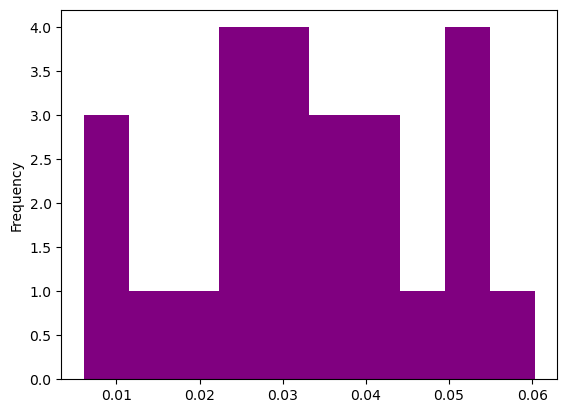

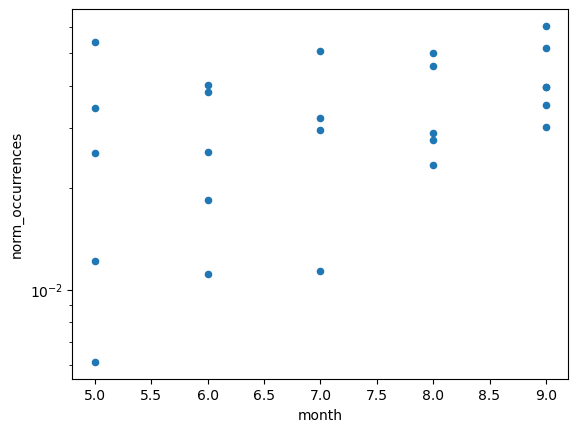

In [29]:
### take a look at it
### plot histogram for ruby-throated occurrences
occur_ruby_df.norm_occurrences.plot.hist(
    color = 'purple'
)

### scatterplot
occur_ruby_df.reset_index().plot.scatter(
    x = 'month',
    y = 'norm_occurrences',
    #c = occur_ruby_df['ecoregion'].astype(float),
    logy = True
)

<Axes: xlabel='month', ylabel='norm_occurrences'>

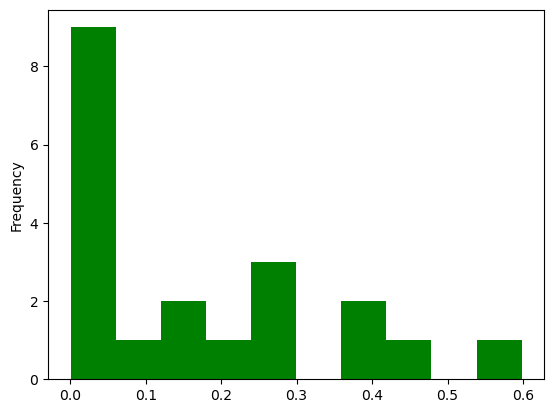

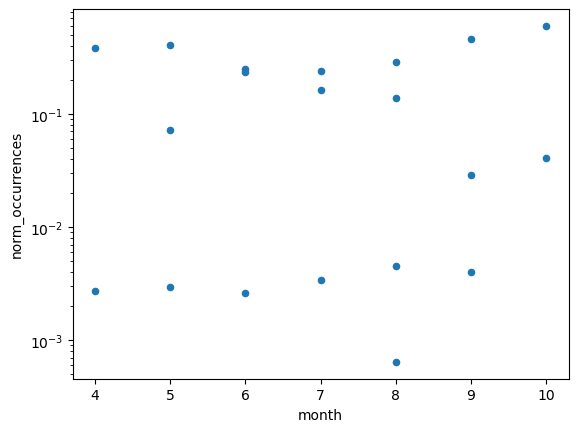

In [30]:
### take a look at it
### plot histogram for ruby-throated occurrences
occur_broad_df.norm_occurrences.plot.hist(
    color = 'green'
)

### scatterplot
occur_broad_df.reset_index().plot.scatter(
    x = 'month',
    y = 'norm_occurrences',
    #c = occur_ruby_df['ecoregion'].astype(float),
    logy = True
)

## Step 9: Make side by side visuals of occurrences

In [31]:
# Simplify the geometry to speed up processing
eco_8_gdf.geometry = eco_8_gdf.simplify(0.1, preserve_topology=False)


# Change the CRS to Mercator for mapping
eco_8_gdf = eco_8_gdf.to_crs(ccrs.Mercator())

# Check that the plot runs in a reasonable amount of time
eco_8_gdf.hvplot(geo=True, crs=ccrs.Mercator())

:Polygons   [Longitude,Latitude]

In [32]:
eco_8_gdf.head()

,US_L3CODE,US_L3NAME,Shape_Area,geometry
0,12,Snake River Plain,2.998087e+07,"POLYGON ((-12361576.654 5389169.732, -12361581..."
1,13,Central Basin and Range,8.226907e+10,"POLYGON ((-12554179.769 5130516.921, -12554034..."
2,14,Mojave Basin and Range,1.950185e+09,"POLYGON ((-12682479.904 4458615.312, -12682274..."
3,15,Northern Rockies,2.912228e+10,"POLYGON ((-12792595.205 6222332.9, -12791815.3..."
4,16,Idaho Batholith,2.373682e+05,"POLYGON ((-12766777.001 5868073.857, -12766906..."


In [33]:
occur_ruby_df.head()

occurrences  norm_occurrences
ecoregion month                               
17        9.0              3          0.039735
26        9.0              3          0.039735
42        5.0              5          0.006106
          6.0              6          0.011143
          8.0             49          0.045880

In [34]:
eco_8_gdf_reset = eco_8_gdf.reset_index()         # 'ecoregion' becomes a column
occur_ruby_df_reset = occur_ruby_df.reset_index() # 'ecoregion' and 'month' become columns
occur_broad_df_reset = occur_broad_df.reset_index() 


In [35]:
eco_8_gdf_reset

,index,US_L3CODE,US_L3NAME,Shape_Area,geometry
0,0,12,Snake River Plain,2.998087e+07,"POLYGON ((-12361576.654 5389169.732, -12361581..."
1,1,13,Central Basin and Range,8.226907e+10,"POLYGON ((-12554179.769 5130516.921, -12554034..."
2,2,14,Mojave Basin and Range,1.950185e+09,"POLYGON ((-12682479.904 4458615.312, -12682274..."
3,3,15,Northern Rockies,2.912228e+10,"POLYGON ((-12792595.205 6222332.9, -12791815.3..."
4,4,16,Idaho Batholith,2.373682e+05,"POLYGON ((-12766777.001 5868073.857, -12766906..."
...,...,...,...,...,...
69,69,80,Northern Basin and Range,1.410431e+07,"POLYGON ((-12519033.45 5132521.629, -12517967...."
70,70,80,Northern Basin and Range,1.276694e+06,"POLYGON ((-12524191.64 5131505.903, -12524587...."
71,71,80,Northern Basin and Range,6.992450e+06,"POLYGON ((-12534450.421 5128603.413, -12535035..."
72,72,80,Northern Basin and Range,3.555776e+06,"POLYGON ((-12553444.685 5130728.493, -12553684..."


In [36]:
eco_8_gdf_reset = eco_8_gdf.rename(columns = {'US_L3CODE': 'ecoregion'})

In [37]:
occur_ruby_df_reset


,ecoregion,month,occurrences,norm_occurrences
0,17,9.0,3,0.039735
1,26,9.0,3,0.039735
2,42,5.0,5,0.006106
3,42,6.0,6,0.011143
4,42,8.0,49,0.045880
5,42,9.0,29,0.051790
6,43,5.0,5,0.012131
7,43,6.0,5,0.018447
8,43,7.0,2,0.011338
9,43,8.0,27,0.050223


In [38]:
occur_ruby_gdf = eco_8_gdf_reset.merge(
    occur_ruby_df_reset,
    on='ecoregion',
    how='inner'
)

In [39]:
occur_broad_gdf = eco_8_gdf_reset.merge(
    occur_broad_df_reset,
    on='ecoregion',
    how='inner'
)

In [40]:
occur_ruby_gdf.crs

<Projected CRS: +proj=merc +ellps=WGS84 +lon_0=0.0 +x_0=0.0 +y_0=0 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Mercator (variant A)
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [41]:
occur_broad_gdf.crs

<Projected CRS: +proj=merc +ellps=WGS84 +lon_0=0.0 +x_0=0.0 +y_0=0 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Mercator (variant A)
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [42]:
eco_8_gdf.crs

<Projected CRS: +proj=merc +ellps=WGS84 +lon_0=0.0 +x_0=0.0 +y_0=0 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Mercator (variant A)
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Step 10: Make some maps of the data!

In [43]:
# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = occur_ruby_gdf.total_bounds

# Define the slider widget
slider = pn.widgets.DiscreteSlider(
    name='month', 
    options={calendar.month_name[i]: i for i in range(1, 13)}
)

# Plot occurrence by ecoregion and month
migrat_ruby_plot = (
    occur_ruby_gdf
    .hvplot(
        c = 'norm_occurrences',
        groupby = 'month',
        
        # Use background tiles
        geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
        title="Ruby-throated Hummingbird Migration, 2024",
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=800,
        widget_location='bottom',
        colorbar = False,
        widgets = {'month': slider}
    )
)
migrat_ruby_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'afa8d03e-f968-466a-8ae4-08d2dc67f910': {'version…

In [44]:
# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = occur_broad_gdf.total_bounds

# Define the slider widget
slider = pn.widgets.DiscreteSlider(
    name='month', 
    options={calendar.month_name[i]: i for i in range(1, 13)}
)

# Plot occurrence by ecoregion and month
migrat_broad_plot = (
    occur_broad_gdf
    .hvplot(
        c = 'norm_occurrences',
        groupby = 'month',
        
        # Use background tiles
        geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
        title="Broad-tailed Hummingbird Migration, 2024",
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=800,
        widget_location='bottom',
        colorbar = False,
        widgets = {'month': slider}
    )
)
migrat_broad_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'ff4d01e4-82c1-40df-a01e-a85c412d3d1c': {'version…

In [45]:
migrat_broad_plot.save('migration-broad-final.html', embed=True)

In [47]:
migrat_ruby_plot.save('migration-ruby-final.html', embed=True)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12,4)) # 1 column and 2 rows
fig.suptitle("Rocky Mountain (Ecoregion 8)")
# Plot each in their own axes
occur_ruby_df.norm_occurrences.plot.hist(ax=axes[0], color ="purple").set_title("Ruby-Throated Hummingbird Occurrences, 2024")

occur_broad_df.norm_occurrences.plot.hist(ax=axes[1], color = "green").set_title("Broad-Tailed Hummingbird Occurrences, 2024"), 

ymax = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, ymax)
axes[1].set_ylim(0, ymax)

plt.tight_layout()
plt.show()


In [ ]:
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12,4)) # 1 column and 2 rows


# Scatterplot
occur_ruby_df.reset_index().plot.scatter(ax=axes[0],
    x = 'month',
    y = 'norm_occurrences',
    #c = 'eco-region',
    logy = True
).set_title("Ruby-Throated Hummingbird Occurrences in 2024")
# Scatterplot
occur_broad_df.reset_index().plot.scatter(ax=axes[1],
    x = 'month',
    y = 'norm_occurrences',
    #c = 'eco-region')
    logy = True
).set_title("Broad-Tailed Hummingbird Occurrences in 2024")

ymax = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, ymax)
axes[1].set_ylim(0, ymax)

xmax = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
axes[0].set_xlim(0, xmax)
axes[1].set_xlim(0, xmax)

plt.tight_layout()
plt.show()

In [ ]:
ruby_hv = migrat_ruby_plot[0].object
broad_hv = migrat_broad_plot[0].object


In [ ]:
'''import holoviews as hv
hv.extension('bokeh')

overlap_plot = overlap.hvplot(
    geo=True,
    size=8,
    color='red',
    alpha=0.5,   # transparency: 0.0=fully transparent, 1.0=opaque
    tiles='OSM',
    legend=False,
    title="Overlap Points with Transparency"
)
overlap_plot'''

In [ ]:
import holoviews as hv
hv.extension('bokeh')

month_dim = ruby_hv.kdims[0]  # usually 'month'

combined_dm = hv.DynamicMap(
    lambda month: (ruby_hv[month]*
                   broad_hv[month]
                  ).opts(
                      title='Ruby vs Broad-Tailed Occurrences in 2024',
                      width=800,
                      height=600,
                      #alpha=0.5
                  ),
    kdims=[month_dim]
)

combined_dm



In [ ]:
hv.save(combined_dm, "ruby_vs_broad_interactive.html")

## Results

While there are more total occurrences of Ruby-Throated hummingbirds across the US, interestingly there are more cases of the Broad-Tailed hummingbird in Ecoregion 8. Also, this research has shown more specific occurrences of the hummingbird species. The ruby-throated hummingbird speices is only seen in the Colorado region in the month of September. 

## Discussion

There does appear to be overlap in migratory patterns of the Ruby-throated hummingbird and the Broad-Tailed hummingbird. Future analysis could look into how many of those occurrences overlap and what topography and climatological regions this is most likely to occur. 

As we can see in the [Interactive Map of Ruby Throated Hummingbirds across North America](https://algrego.github.io/img/migration-ruby-final.html), There are occurrences of this species all across the US, but do not appear prominently in Colorado until the month of September. As we can see in the [Interactive Map of Broad-tailed Hummingbirds across North America](https://algrego.github.io/img/migration-broad-final.html), this species exists much more prominently across the western US and Colorado across all months. 

Looking at the [Interactive Map of Ruby Throated Hummingbirds for Ecoregion 8](https://algrego.github.io/img/migration-ruby-final-8.html) we can see more clearly how uncommon this species is to the region. Comparatively, in the [Interactive Map of the Broad-tailed Hummingbirds for Ecoregion 8](https://algrego.github.io/img/migration-broad-final-8.html).
    
## Citations

- Blumhardt, Miles. Colorado hummingbirds: When they arrive, how to identify them and attract them to your yard. 2024. Fort Collins Coloradoan. https://www.coloradoan.com/story/news/2024/05/17/here-is-when-you-can-expect-to-start-seeing-hummingbirds-in-colorado/73662783007/?gnt-cfr=1&gca-cat=p&gca-uir=true&gca-epti=z113828d00----v113828d--43--b--43--&gca-ft=169&gca-ds=sophi 

- Prieto-Torres, D. A., Nunez Rosas, L. E., Figueroa, D.R., and Arizmendi, M.D.C. 2021. Most Mexican hummingbirds lose under climate and land-use change: Long-term conservation impacts. Perspectives in Ecology and Conservation, v. 19, no. 4, p. 487-499. https://doi.org/10.1016/j.pecon.2021.07.001.

- Guevara, E.A., Bello, C., Poveda, C., McFadden, I.R., Schleuning, M., Pellissier, L., and Graham, C.H.  2023. Hummingbird community structure and nectar resources modulate the response of interspecific competition to forest conversion. Oecologia, v. 201, p. 761-770.  https://doi.org/10.1007/s00442-023-05330-z 
- Rashid, Scott. Hummingbirds of Colorado. 2021. Hike Rocky Magazine. https://issuu.com/hikerockymagazine/docs/hike_rocky_magazine_june_2021/s/12829838 

- U.S. Fish and Wildlife Service. Hummingbirds of North America. 2024. https://www.fws.gov/story/hummingbirds-north-america 

- U.S. Department of Agriculture. Maintaining and Improving Habitat for Hummingbirds in Colorado, Wyoming, and South Dakota. https://www.fs.usda.gov/wildflowers/pollinators/documents/HummingbirdBrochures/HummingbirdGuideCO-WY-SD.pdf 
